# Figure A2: Author-specific treatment effects

In [1]:
source('../scripts/load_libraries.R')
source('../scripts/load_constants.R')


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Please cite as: 


 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.

 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



Attaching package: ‘lemon’


The following objects are masked from ‘package:ggplot2’:

    CoordCartesian, element_render




In [2]:
source('../scripts/load_data.R')

Rows: 17264341 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (5): comment_id, user_id, author_id, anonymous, first_view

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1281001 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, score, time_stamp

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 223737 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
dbl (4): comment_id, user_id, num, time_stamp

ℹ Use `spec()` t

In [3]:
dfa2 <- df_clean %>%
  group_by(author_id) %>%
  mutate(n = n()) %>%
  ungroup %>%
  mutate(author_id2 = factor(ifelse(n >= 16210, author_id, -1)))

In [4]:
iteregs <- dfa2 %>%
  mutate(rp = as.numeric(rp > 0)) %>%
  group_by(author_id2) %>% do({
    m2_up <- felm(up ~ identified | user_id | 0 | user_id, data = .,
                  keepX = FALSE)
    m2_dn <- felm(dn ~ identified | user_id | 0 | user_id, data = .,
                  keepX = FALSE)
    m2_rp <- felm(rp ~ identified | user_id | 0 | user_id, data = .,
                  keepX = FALSE)
    bind_rows(broom::tidy(m2_up) %>% mutate(outcome = 'up'),
              broom::tidy(m2_dn) %>% mutate(outcome = 'dn'),
              broom::tidy(m2_rp) %>% mutate(outcome = 'rp'))
  })

In [5]:
for_plot <- iteregs %>%
  ungroup() %>%
  filter(term == 'identified') %>%
  mutate(outcome = fct_relevel(outcome, 'up', 'dn', 'rp'),
         outcome = fct_recode(outcome, `Up-vote` = 'up', `Down-vote` = 'dn', `Reply` = 'rp')) %>%
  group_by(outcome) %>%
  arrange(estimate) %>%
  mutate(rnk = row_number(),
         ucl = 100 * (estimate + 1.96 * std.error),
         lcl = 100 * (estimate - 1.96 * std.error),
         sig = if_else(abs(estimate) > 1.96 * std.error, 'yes', 'no'))

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”


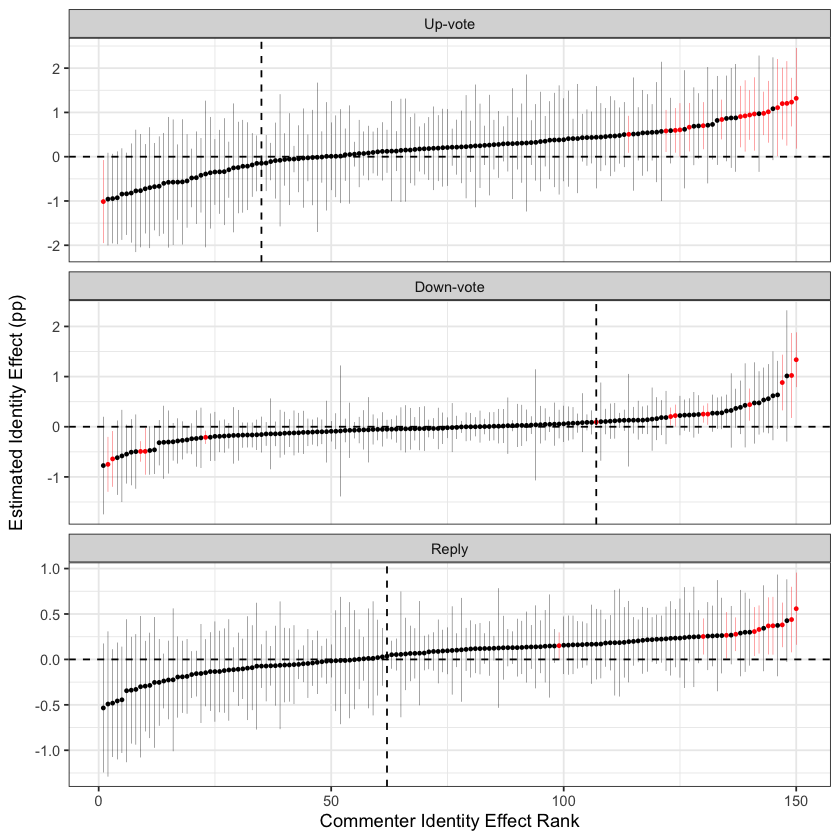

In [6]:
p1 <- for_plot %>%
  ggplot(aes(x = rnk, y = 100 * estimate,
             ymin = 100 * (estimate - 1.96 * std.error),
             ymax = 100 * (estimate + 1.96 * std.error),
             colour = sig)) +
  geom_pointrange(size = 0.1, fatten = 0.25) +
  scale_color_manual(values=c("black", "red"), guide = FALSE) +
  geom_hline(yintercept = 0.0, linetype = 'dashed') +
  geom_vline(data = for_plot %>% filter(author_id2 == '-1'), aes(xintercept = rnk), linetype = 'dashed') +
  facet_wrap('outcome', ncol = 1, scales = 'free_y') +
  xlab('Commenter Identity Effect Rank') +
  ylab('Estimated Identity Effect (pp)') +
  theme_bw()
p1

In [7]:
ggsave('../figures/fig-a2.pdf', p1, width = 5.5, height = 5)

Warning message:
“It is deprecated to specify `guide = FALSE` to remove a guide. Please use `guide = "none"` instead.”
